# Training and Testing

In [1]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output, display
from sklearn import preprocessing
import copy
from matplotlib.pyplot import figure
from scipy.fft import fft
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tqdm
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import pickle
import joblib
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Training on Marri001

In [2]:
df_dataset = pd.read_csv("AllChannels_MarRi001_Features_2.csv")
df_dataset = df_dataset.drop(columns="Unnamed: 0")

In [24]:
# Standardize data
ss = StandardScaler()
df_scaled = pd.DataFrame(ss.fit_transform(df_dataset),columns = df_dataset.columns)
df_dataset = df_scaled

In [25]:
# Split train and test data
features = df_dataset.loc[:, df_dataset.columns != 'Label'].values
labels = df_dataset["Label"].values
print(features.shape)

# X_train = features[0:int(features.shape[0]/2)][:]
# y_train = labels[0:int(labels.shape[0]/2)][:]

# X_test = features[int(features.shape[0]/2):][:]
# y_test = labels[int(labels.shape[0]/2):][:]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=8,shuffle=False)

(306902, 42)


In [38]:
def plot_confusion_matrix(labels,preds):
        cm = metrics.confusion_matrix(labels, preds)
        plt.figure(figsize=(6,6))
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.title('Confusion matrix', size = 15)
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ["0", "1"], rotation=0, size = 10)
        plt.yticks(tick_marks, ["0", "1"], size = 10)
        plt.tight_layout()
        plt.ylabel('Actual label', size = 15)
        plt.xlabel('Predicted label', size = 15)
        width, height = cm.shape 
        for x in range(width):
            for y in range(height):
                plt.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center',verticalalignment='center')

In [15]:
def filter_preds(preds,ws):
        for i in range(0,len(preds)) :
            if (i+ws) > len(preds):
                ws = len(preds) - i
            window = preds[i:i+ws]
            if np.mean(window) < 0.5:
                preds[i] = 0
            else:
                preds[i] = 1
        return preds

# Random Forest

In [5]:
classifier = RandomForestClassifier(n_estimators=100,max_depth=8)
classifier.fit(X_train,y_train)

RandomForestClassifier(max_depth=8)

In [8]:
classifier.score(X_test,y_test)

0.6905431677726972

# Neural Network

In [36]:
model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=4, batch_size=100)

Epoch 1/4
2149/2149 [==============================] - 2s 731us/step - loss: 0.2795 - accuracy: 0.3567
Epoch 2/4
2149/2149 [==============================] - 2s 743us/step - loss: -0.3744 - accuracy: 0.4030
Epoch 3/4
2149/2149 [==============================] - 2s 743us/step - loss: -1.1865 - accuracy: 0.4097
Epoch 4/4
2149/2149 [==============================] - 2s 743us/step - loss: -2.2743 - accuracy: 0.4120


Accuracy: 0.6297857088551226


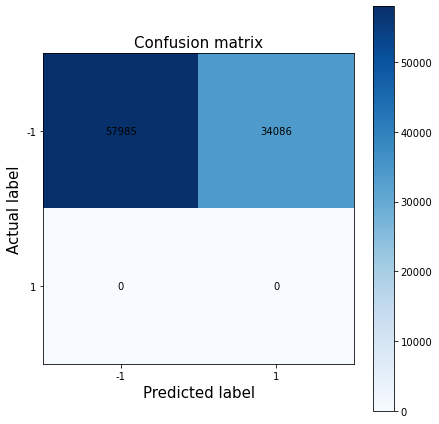

In [42]:
y_test = [(x+1)/2 for x in y_test]
preds = model.predict(X_test)
threshold = 0.5
preds[preds > threshold] = 1
preds[preds <= threshold] = 0
plot_confusion_matrix(y_test,preds)
acc = accuracy_score(y_test, preds)
print("Accuracy: " + str(acc))

# Boosted Trees

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
model2 = GradientBoostingClassifier()
model2.fit(X_train, y_train)

GradientBoostingClassifier()

In [9]:
model2.score(X_test,y_test)

0.6857099412409988

# Testing on Marri007

In [47]:
signal_df = pd.read_csv("AllChannels_MarRi007_Features_2.csv")
signal_df = signal_df.drop(columns="Unnamed: 0")

In [48]:
# Standardize data
df_scaled = pd.DataFrame(ss.transform(signal_df),columns = signal_df.columns)
signal_df = df_scaled

In [54]:
# Split train and test data
features = signal_df.loc[:, signal_df.columns != 'Label'].values
labels = signal_df["Label"].values
print(features.shape)

# X_train = features[0:int(features.shape[0]/2)][:]
# y_train = labels[0:int(labels.shape[0]/2)][:]

# X_test = features[int(features.shape[0]/2):][:]
# y_test = labels[int(labels.shape[0]/2):][:]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.999, random_state=8,shuffle=False)

(375100, 42)


# Random Forest

In [55]:
classifier.score(X_test,y_test)

0.5942704650076723

# Boosted Trees

In [56]:
model2.score(X_test,y_test)

0.3854266462072186

# Neural Network

Accuracy: 0.591911401694576


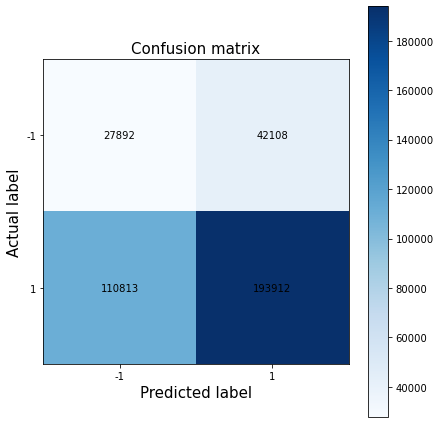

In [57]:
preds = model.predict(X_test)
threshold = 0.5
preds[preds > threshold] = 1
preds[preds <= threshold] = 0
plot_confusion_matrix(y_test,preds)
acc = accuracy_score(y_test, preds)
print("Accuracy: " + str(acc))

# ROC - AUC evaluated for the MLP

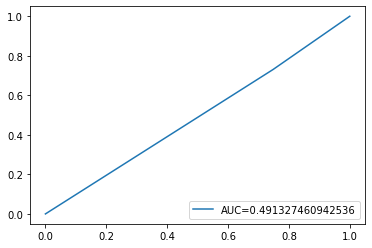

In [60]:
y_pred_proba = classifier.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()